Check custom scaling outputs
============================

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import BQ
import util_funcs as uf
from google.cloud import bigquery

In [27]:
output_folder = 'Outputs/'
output_prices = pd.read_csv(output_folder+'Price_Changes_Scaling_August_02.csv', dtype={'GPI': str, 'NDC': str})

In [28]:
customer_id_list = ['2701']

In [29]:
desired_r30 = {'2701': 1-0.24,
              }
desired_r90 = {'2701': 1-0.24,
              }
desired_mail = {'2701': 1-0.24,
               }

In [30]:
bqclient = bigquery.Client()
raw_prices = bqclient.query(
    f"""select customer_id, chnl_ind, maclist.* from `anbc-prod.fdl_gdp_ae_ds_pro_lp_share_ent_prod.mac_list` maclist
        join `anbc-prod.fdl_gdp_ae_ds_pro_lp_share_ent_prod.vcml_reference` vcml_ref on vcml_ref.vcml_id=maclist.mac
        where customer_id in ("{'", "'.join(customer_id_list)}")
     """
).to_dataframe()

In [31]:
raw_prices.head()

,customer_id,chnl_ind,MAC,GPI,NDC,PRICE,GPI_NDC,MAC_LIST
0,2701,M30,MAC27012,44201010103410,72572001401,6.2830,44201010103410_72572001401,27012
1,2701,M30,MAC27012,49270060006530,***********,0.1964,49270060006530_***********,27012
2,2701,M30,MAC27012,86802320001820,***********,29.3155,86802320001820_***********,27012
3,2701,M30,MAC27012,55100018103720,***********,2.2444,55100018103720_***********,27012
4,2701,M30,MAC27012,43993003210420,***********,0.4099,43993003210420_***********,27012


In [32]:
output_prices.head()

,MACLIST,GPI,GPPC,NDC11,NAME,EFFDATE,TERMDATE,CurrentMAC,client_name,MACPRC,AT_RUN_ID
0,MAC27011,72600065000330,********,***********,NaN,20232922,20391231,7.4055,2701,5.6282,CS20230802000000000002701
1,MAC27011,39400075000320,********,***********,NaN,20232922,20391231,0.0303,2701,0.0230,CS20230802000000000002701
2,MAC27011,34000018100120,********,***********,NaN,20232922,20391231,5.4743,2701,4.1605,CS20230802000000000002701
3,MAC27011,72600075006820,********,***********,NaN,20232922,20391231,0.5553,2701,0.4220,CS20230802000000000002701
4,MAC27011,61400020102030,********,***********,NaN,20232922,20391231,0.8481,2701,0.6446,CS20230802000000000002701


In [33]:
print("combo prices before", len(raw_prices), len(output_prices))
combo_prices = raw_prices.merge(output_prices, left_on=['MAC', 'GPI', 'NDC'], right_on=['MACLIST', 'GPI', 'NDC11'], how='left')
combo_prices['CHANGED'] = ~combo_prices['MACPRC'].isna()
combo_prices['NEW_PRICE'] = combo_prices['MACPRC']
combo_prices.loc[combo_prices['NEW_PRICE'].isna(), 'NEW_PRICE'] = combo_prices.loc[combo_prices['PRICE'].isna(), 'NEW_PRICE']
print("combo prices after", len(raw_prices), len(output_prices), "with", combo_prices['CHANGED'].sum(), 'changed prices')


combo prices before 7332 6788
combo prices after 7332 6788 with 6788 changed prices


In [34]:
overrides_1 = uf.read_BQ_data(
        BQ.gpi_change_exclusion_ndc,
        project_id='anbc-prod',
        dataset_id='fdl_gdp_ae_ds_pro_lp_share_ent_prod',
        table_id='gpi_change_exclusion_ndc'
    )


Imported 4411 rows and 2 columns from BQ table gpi_change_exclusion_ndc


In [35]:
overrides_1[overrides_1['GPI_CD']=='21360030000320']

,GPI_CD,DRUG_ID
1286,21360030000320,50742036630
1287,21360030000320,00480405356
1288,21360030000320,69339016803
1289,21360030000320,60505451203
1290,21360030000320,00310048230


In [36]:
overrides_3 = []
for customer_id in customer_id_list:
    overrides_3.append(uf.read_BQ_data(
            BQ.wmt_unc_override_custom.format(_customer_id = uf.get_formatted_string([customer_id]),
                                              _project = "pbm-mac-lp-prod-ai",
                                              _dataset = 'ds_sandbox',
                                              _table = "wmt_unc_override"),
            project_id =  "pbm-mac-lp-prod-ai",
            dataset_id = 'ds_sandbox',
            table_id = "wmt_unc_override",
            custom = True
        ))
overrides_3 = pd.concat(overrides_3)

Imported 0 rows and 10 columns from BQ table wmt_unc_override


In [37]:
overrides_2 = []
for customer_id in customer_id_list:
    overrides_2.append(uf.read_BQ_data(
            BQ.ger_opt_mac_price_override_custom.format(_customer_id = uf.get_formatted_string([customer_id]),
                                                        _project = 'anbc-prod',
                                                        _landing_dataset = 'fdl_gdp_ae_ds_pro_lp_share_ent_prod',
                                                        _table_id = "ger_opt_mac_price_override"),
            project_id='anbc-prod',
            dataset_id='fdl_gdp_ae_ds_pro_lp_share_ent_prod',
            table_id="ger_opt_mac_price_override",
            custom = True
        ))
overrides_2 = pd.concat(overrides_2)

Imported 752 rows and 9 columns from BQ table ger_opt_mac_price_override


In [38]:
# Check number of changes per vcml
for cid in customer_id_list:
    cid = str(cid)
    print("Customer ID", cid)
    cp = combo_prices[(combo_prices['customer_id']==cid) & combo_prices['CHANGED']]
    print(cp['MAC_LIST'].value_counts())
    print("-------------------------------------------")

Customer ID 2701
27012    2264
27011    2262
27013    2262
Name: MAC_LIST, dtype: int64
-------------------------------------------


Customer ID 2701


/var/tmp/ipykernel_4106257/2563499057.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp_r['ratio'] = cp_r['MACPRC']/cp_r['CurrentMAC']


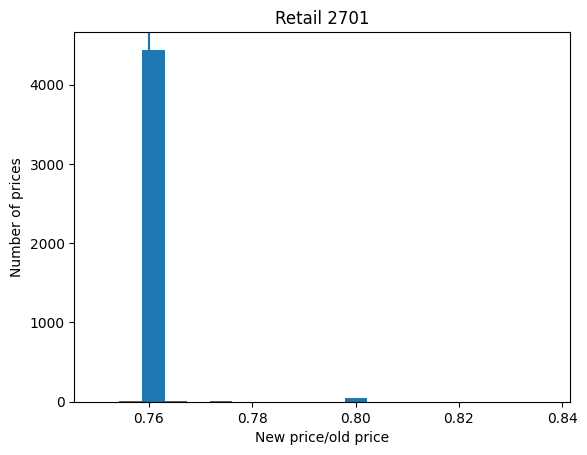

In [39]:
# Check distribution of changes for retail
for cid in customer_id_list:
    cid = str(cid)
    print("Customer ID", cid)
    cp_r = combo_prices[(combo_prices['customer_id']==cid) & combo_prices['CHANGED'] & (combo_prices['chnl_ind']!='M30') & (combo_prices['MACPRC']!=combo_prices['CurrentMAC'])]
    cp_r['ratio'] = cp_r['MACPRC']/cp_r['CurrentMAC']
    fig, ax = plt.subplots()
    ax.hist(cp_r['ratio'], bins=20)
    ax.axvline(desired_r30[cid])
    ax.axvline(desired_r90[cid])
    ax.set_xlabel("New price/old price")
    ax.set_ylabel("Number of prices")
    ax.set_title("Retail "+cid)




Customer ID 2701


/var/tmp/ipykernel_4106257/2026798003.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp_m['ratio'] = cp_m['MACPRC']/cp_m['CurrentMAC']


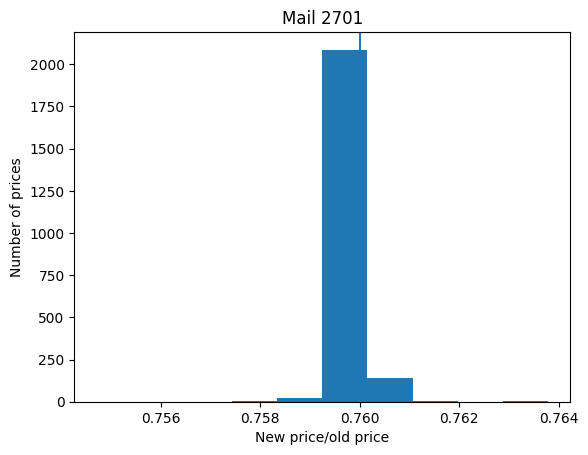

In [40]:
# Check distribution of changes for mail
for cid in customer_id_list:
    cid = str(cid)
    print("Customer ID", cid)
    cp_m = combo_prices[(combo_prices['customer_id']==cid) & combo_prices['CHANGED'] & (combo_prices['chnl_ind']=='M30') & (combo_prices['MACPRC']!=combo_prices['CurrentMAC'])]
    cp_m['ratio'] = cp_m['MACPRC']/cp_m['CurrentMAC']
    fig, ax = plt.subplots()
    ax.hist(cp_m['ratio'])
    ax.axvline(desired_mail[cid])
    ax.set_xlabel("New price/old price")
    ax.set_ylabel("Number of prices")
    ax.set_title("Mail "+cid)


In [41]:
combo_prices['IS_MAIL'] = combo_prices['chnl_ind']=='M30'
combo_prices['IS_R90'] = combo_prices['chnl_ind'].str.contains('90')

In [42]:
# Check CVS parity

for cid in customer_id_list:
    cid = str(cid)
    cp = combo_prices[(combo_prices['customer_id']==cid) & ~combo_prices['IS_R90'] & ~combo_prices['IS_MAIL']]
    if 'CVSSP' in cp['chnl_ind'].unique():
        match_vcml = 'CVSSP'
    else:
        match_vcml = 'CVS'
    min_retail = cp[cp['chnl_ind']!=match_vcml].groupby(['GPI', 'NDC'], as_index=False).agg({'NEW_PRICE': min, 'CHANGED': any}).rename(columns={'NEW_PRICE': 'COMPARISON_PRICE', 'CHANGED': 'COMPARISON_CHANGED'})
    cp_check = cp[cp['chnl_ind']==match_vcml].merge(min_retail, on=['GPI', 'NDC'])
    cp_check = cp_check[cp_check['CHANGED'] | cp_check['COMPARISON_CHANGED']]
    print("Violations for", cid, " R30:", (cp_check['NEW_PRICE']>cp_check['COMPARISON_PRICE']).sum())
    cp = combo_prices[(combo_prices['customer_id']==cid) & combo_prices['IS_R90']]
    if cp.empty:
        continue
    if 'CVSSP90' in cp['chnl_ind'].unique():
        match_vcml = 'CVSSP90'
    elif 'CVS90' in cp['chnl_ind'].unique():
        match_vcml = 'CVS90'
    else:
        match_vcml = 'R90'
    min_retail = cp[cp['chnl_ind']!=match_vcml].groupby(['GPI', 'NDC'], as_index=False).agg({'NEW_PRICE': min, 'CHANGED': any}).rename(columns={'NEW_PRICE': 'COMPARISON_PRICE', 'CHANGED': 'COMPARISON_CHANGED'})
    cp_check = cp[cp['chnl_ind']==match_vcml].merge(min_retail, on=['GPI', 'NDC'])
    cp_check = cp_check[cp_check['CHANGED'] | cp_check['COMPARISON_CHANGED']]
    print("Violations for", cid, " R90:", (cp_check['NEW_PRICE']>cp_check['COMPARISON_PRICE']).sum())    
    if(cp_check['NEW_PRICE']>cp_check['COMPARISON_PRICE']).any():
        print(cp_check[cp_check['NEW_PRICE']>cp_check['COMPARISON_PRICE']])

Violations for 2701  R30: 0
Violations for 2701  R90: 0


In [43]:
# Check R30-R90

for cid in customer_id_list:
    cid = str(cid)
    cp = combo_prices[(combo_prices['customer_id']==cid) & ~combo_prices['IS_MAIL']]
    chnl_ind_list = cp['chnl_ind'].unique()
    print(chnl_ind_list)
    if not any(['90' in chnl_ind for chnl_ind in chnl_ind_list]):
        continue
    for chnl_ind in chnl_ind_list:
        if '90' in chnl_ind:
            continue
        if (chnl_ind+'90' in chnl_ind_list) or (chnl_ind+' 90' in chnl_ind_list):
            comp_r90 = chnl_ind+'90'
        elif chnl_ind in ('WAG', 'WMT', 'RAD', 'KGR', 'KRG') and 'R90CH' in chnl_ind_list:
            comp_r90 = 'R90CH'
        else:
            comp_r90 = 'R90'
        cp30 = cp[cp['chnl_ind']==chnl_ind]
        cp90 = cp[cp['chnl_ind']==comp_r90]
        cp_check = cp30.merge(cp90, on=['GPI', 'NDC'], suffixes=('_R30', '_R90'))
        cp_check = cp_check[cp_check['CHANGED_R30'] | cp_check['CHANGED_R90']]
        print("Violations for", cid, chnl_ind, ":", (cp_check['NEW_PRICE_R90']>cp_check['NEW_PRICE_R30']+0.0001).sum())

['R30' 'R90']
Violations for 2701 R30 : 0


In [44]:
# Check Mail - min(R30, R90)
# Check CVS parity

for cid in customer_id_list:
    cid = str(cid)
    cp = combo_prices[(combo_prices['customer_id']==cid) & ~combo_prices['IS_MAIL']]
    min_retail = cp.groupby(['GPI', 'NDC'], as_index=False).agg({'NEW_PRICE': min, 'CHANGED': any}).rename(columns={'NEW_PRICE': 'COMPARISON_PRICE', 'CHANGED': 'COMPARISON_CHANGED'})
    cp_check = combo_prices[(combo_prices['customer_id']==cid) & combo_prices['IS_MAIL']].merge(min_retail, on=['GPI', 'NDC'])
    cp_check = cp_check[cp_check['CHANGED'] | cp_check['COMPARISON_CHANGED']]
    print("Violations for", cid, " MAIL:", (cp_check['NEW_PRICE']>cp_check['COMPARISON_PRICE']).sum())


Violations for 2701  MAIL: 0


In [45]:
# check overrides 1
changed = combo_prices[combo_prices['CHANGED']]
print("Disallowed prices changed:", changed['GPI'].isin(overrides_1['GPI_CD'].unique()).sum())



Disallowed prices changed: 0


In [46]:
changed[changed['GPI'].isin(overrides_1['GPI_CD'].unique())]

,customer_id,chnl_ind,MAC,GPI,NDC,PRICE,GPI_NDC,MAC_LIST,MACLIST,GPPC,...,EFFDATE,TERMDATE,CurrentMAC,client_name,MACPRC,AT_RUN_ID,CHANGED,NEW_PRICE,IS_MAIL,IS_R90


In [47]:
# check overrides 2
for customer_id in customer_id_list:
    o2 = overrides_2[overrides_2['CLIENT']==str(customer_id)]
    ch = changed[changed['customer_id']==str(customer_id)]
    print("Disallowed prices changed for", customer_id, ":", ch['GPI'].isin(o2['GPI'].unique()).sum())

Disallowed prices changed for 2701 : 0


In [48]:
# check overrides 3
for customer_id in customer_id_list:
    o3 = overrides_3[overrides_3['CLIENT']==str(customer_id)]
    for vcml_id in o3['VCML_ID'].unique():
        o3v = overrides_3[overrides_3['VCML_ID']==vcml_id]
        ch = changed[(changed['customer_id']==str(customer_id)) & (changed['MACLIST']==vcml_id)]
        print("Disallowed prices changed for", customer_id, vcml_id, ":", ch['GPI'].isin(o3v['GPI'].unique()).sum(), "out of", len(ch))